### Part 1: Data Pre-processing

```shell
!pip install -U kardiasclean
```

#### Step 1: Load Data from CSV

Load csv and merge them with pandas to create a dataframe with repeated patient data but unique surgical procedure per patient.

In [47]:
import pandas as pd
import kardiasclean
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [48]:
#procedure_per_patient_df.dropna(inplace=True)

In [49]:
# load
patient_df = pd.read_csv("db_patient.csv")
procedure_per_patient_df = pd.read_csv("db_patient_surgical_procedure_cleaned.csv")

In [50]:
procedure_per_patient_df.fillna("Other", inplace=True)

In [51]:
# merge
df = pd.merge(patient_df, procedure_per_patient_df)
print(df.columns)
df[5:10]

Index(['patient_id', 'gender', 'age_days', 'weight_kg', 'height_cm',
       'cx_previous', 'date_birth', 'date_procedure', 'rachs', 'stay_days',
       'expired', 'surgical_procedure'],
      dtype='object')


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired,surgical_procedure
5,5,1,2888,34.4,134.0,0,2004-08-31,2012-08-09,2,2,0,Vena cava inferior parche
6,5,1,2888,34.4,134.0,0,2004-08-31,2012-08-09,2,2,0,Reparacion de estenosis aortica
7,6,0,3828,37.0,141.0,0,2002-04-02,2012-09-22,2,2,0,Vena cava inferior parche
8,7,0,1583,13.5,102.0,0,2008-06-05,2012-09-29,1,2,0,Parche comunicacion interauricular CIA
9,8,1,3549,37.0,137.0,0,2002-04-12,2012-10-13,2,5,0,Vena cava inferior parche


#### Step 2: High and Low Frequency Categories (Exploratory)

We can play with the QUANTILE variable to find a good signal to noise ratio (assuming that the low frequency values can add noise to the model). This is only so we can get an idea of how much data is binned in the next step.

In [52]:
QUANTILE = 0.70
low, high = kardiasclean.perform_frequency_split_quantile(df['surgical_procedure'], QUANTILE)
print(kardiasclean.evaluate_distribution(high, low))

Total data (repeated): 1663
--------------------
Unique high frequency data: 10
Unique low frequency data: 21
--------------------
Total high frequency data: 1401
Total low frequency data: 262
--------------------
Percentage of high data: 84.25%
Percentage of low data: 15.75%
--------------------
Summary
--------------------
From 1663 data, 10 account for 84.25% of the total count.



#### Step 3: Bin Low Frequency Data

Convert all low frequency categorical variables to "Other".

In [53]:
df['surgical_procedure'] = kardiasclean.perform_binning_quantile(df['surgical_procedure'], QUANTILE)
df['surgical_procedure']

0       Parche comunicacion interauricular CIA
1       Parche comunicacion interauricular CIA
2       Parche comunicacion interauricular CIA
3       Parche comunicacion interauricular CIA
4       Parche comunicacion interauricular CIA
                         ...                  
1658                Reparacion de arco aortico
1659                                     Other
1660        Reparacion de Tetralogia de Fallot
1661                                     Other
1662                                     Other
Name: surgical_procedure, Length: 1663, dtype: object

#### Step 4: Deal with dates
We are going to replace the date of birth and date of procedure with a new value that will be the difference of the two so we can use it as a number in our model.

**NOTE**: The age_days and date_delta have a linear relationship so maybe we can drop one in favor of the other.

,age_days,date_delta
0,3942,3882
1,3202,3338
2,3147,3193
3,4005,3975
4,5289,5131


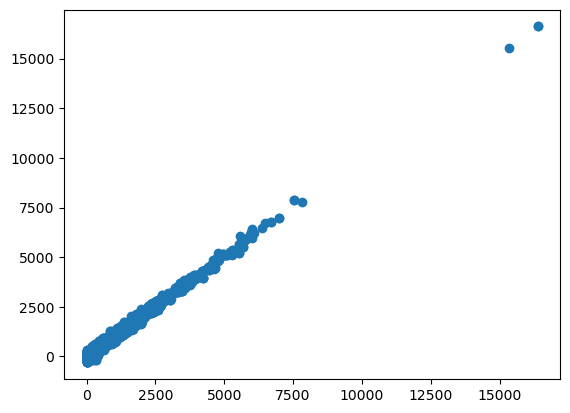

In [54]:
df['date_delta'] = (pd.to_datetime(df['date_procedure']) - pd.to_datetime(df['date_birth'])).dt.days
plt.scatter(df['age_days'], df['date_delta'])
df[0:5][['age_days', 'date_delta']]

In [55]:
# Drop unnecessary dates / ages
df = df.drop(columns=["date_birth", "date_procedure", 'age_days'])
df[5:10]

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,surgical_procedure,date_delta
5,5,1,34.4,134.0,0,2,2,0,Vena cava inferior parche,2900
6,5,1,34.4,134.0,0,2,2,0,Other,2900
7,6,0,37.0,141.0,0,2,2,0,Vena cava inferior parche,3826
8,7,0,13.5,102.0,0,1,2,0,Parche comunicacion interauricular CIA,1577
9,8,1,37.0,137.0,0,2,5,0,Vena cava inferior parche,3837


#### Step 5: Encode Categorical Data and Merge

We are going to encode the categorical data and merge it with the original.

In [56]:
encoded = kardiasclean.perform_matrix_encoding(df['surgical_procedure'], df['patient_id'])
merged_df = pd.merge(df, encoded).drop('surgical_procedure', axis=1)
merged_df[5:10]

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,date_delta,surgical_procedure_Parche comunicacion interauricular CIA,surgical_procedure_Vena cava inferior parche,surgical_procedure_Other,surgical_procedure_Cierre de Conducto Arterioso,surgical_procedure_Reparacion de Canal AV,surgical_procedure_Reparacion de Tetralogia de Fallot,surgical_procedure_Procedimiento de Glenn,surgical_procedure_Reparacion de arco aortico,surgical_procedure_Fistula sistemico pulmonar,surgical_procedure_Procedimiento de Fontan
5,5,1,34.4,134.0,0,2,2,0,2900,0,1,1,0,0,0,0,0,0,0
6,5,1,34.4,134.0,0,2,2,0,2900,0,1,1,0,0,0,0,0,0,0
7,6,0,37.0,141.0,0,2,2,0,3826,0,1,0,0,0,0,0,0,0,0
8,7,0,13.5,102.0,0,1,2,0,1577,1,0,0,0,0,0,0,0,0,0
9,8,1,37.0,137.0,0,2,5,0,3837,0,1,0,0,0,0,0,0,0,0


#### Step 6: Group all Duplicated Patients
In this case, we want to group by patient_id so one row can have a 1 value in multiple categorical columns. This is optional as we could decide to not consider overlapping procedures.

In [57]:
final_df = merged_df.groupby("patient_id").mean()
print("Before merging", merged_df.shape)
print("After merging", final_df.shape)
final_df[5:10]

Before merging (1663, 19)
After merging (1003, 18)


,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,date_delta,surgical_procedure_Parche comunicacion interauricular CIA,surgical_procedure_Vena cava inferior parche,surgical_procedure_Other,surgical_procedure_Cierre de Conducto Arterioso,surgical_procedure_Reparacion de Canal AV,surgical_procedure_Reparacion de Tetralogia de Fallot,surgical_procedure_Procedimiento de Glenn,surgical_procedure_Reparacion de arco aortico,surgical_procedure_Fistula sistemico pulmonar,surgical_procedure_Procedimiento de Fontan
patient_id,,,,,,,,,,,,,,,,,,
5,1.0,34.4,134.0,0.0,2.0,2.0,0.0,2900.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,37.0,141.0,0.0,2.0,2.0,0.0,3826.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,13.5,102.0,0.0,1.0,2.0,0.0,1577.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,37.0,137.0,0.0,2.0,5.0,0.0,3837.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,62.0,162.0,0.0,1.0,2.0,0.0,5676.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 2: Questions and ML

We are going to use questions to pick our ML models.

#### Step 1: Target and Features

##### **Question**: Given the patient data including surgical procedures, will the patient stay more than a week in intensive care? (> 7 days)


In [58]:
# Target
y = final_df["stay_days"].map(lambda x: 1 if x > 5 else 0).values # create binary target
X = final_df.drop(["stay_days", "expired"], axis=1).values
print("Records with less than 5 days:", y[y==0].shape[0])
print("Records with more than 5 days:", y[y==1].shape[0])

Records with less than 5 days: 586
Records with more than 5 days: 417


In [59]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Normalize
scaler = StandardScaler()
X_scaler = scaler.fit(X)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape, y_train.shape

((752, 16), (752,))

#### Step 2: Neural Network
We pick a model depending on our target.

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#work-with-hyperparameters

In [60]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
dim = len(X_train_scaled[0])
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="tanh", input_dim=dim))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="linear"))
# Third hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="relu"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 60)                1020      
                                                                 
 dense_13 (Dense)            (None, 60)                3660      
                                                                 
 dense_14 (Dense)            (None, 60)                3660      
                                                                 
 dense_15 (Dense)            (None, 1)                 61        
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


#### Step 3: Train and Predict

We compile and fit the model. Then make a prediction.

In [61]:
# Train
optimizer = tf.keras.optimizers.Adam(0.0001) # set learning rate
# LOSS: binary_crossentropy, mean_squared_error
nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs=120, verbose=1)

Epoch 1/120
24/24 [==============================] - 1s 2ms/step - loss: 0.7286 - accuracy: 0.4402
Epoch 2/120
24/24 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5691
Epoch 3/120
24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6609
Epoch 4/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.7021
Epoch 5/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5684 - accuracy: 0.7168
Epoch 6/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5505 - accuracy: 0.7354
Epoch 7/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5358 - accuracy: 0.7420
Epoch 8/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5252 - accuracy: 0.7540
Epoch 9/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5163 - accuracy: 0.7553
Epoch 10/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5097 - accuracy: 0.7620
Epoch 11/

24/24 [==============================] - 0s 3ms/step - loss: 0.4457 - accuracy: 0.7939
Epoch 84/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4452 - accuracy: 0.7965
Epoch 85/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4448 - accuracy: 0.7926
Epoch 86/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4446 - accuracy: 0.7979
Epoch 87/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4444 - accuracy: 0.7939
Epoch 88/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4437 - accuracy: 0.7952
Epoch 89/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.7952
Epoch 90/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.7965
Epoch 91/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.7992
Epoch 92/120
24/24 [==============================] - 0s 3ms/step - loss: 0.4426 - accuracy: 0.7992
Epoch 93/120


#### Step 4: Evaluate

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#visualize-the-results

In [62]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.4252 - accuracy: 0.8287 - 217ms/epoch - 27ms/step
Loss: 0.42519354820251465, Accuracy: 0.8286852836608887


<AxesSubplot:title={'center':'loss'}>

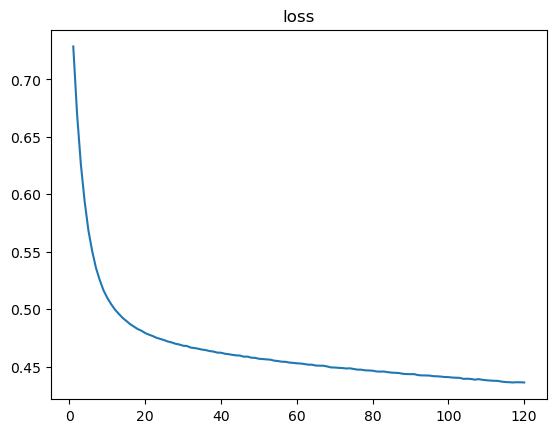

In [63]:
%matplotlib inline
# view loss function
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df['loss'].plot(title="loss")

In [64]:
y_pred = nn.predict(X_test_scaled)
y_pred[0:10]

8/8 [==============================] - 0s 2ms/step


array([[0.8872099 ],
       [0.01800149],
       [0.89133584],
       [0.20252597],
       [0.06637679],
       [0.6793651 ],
       [0.18389897],
       [0.6896803 ],
       [0.45117202],
       [0.1883469 ]], dtype=float32)

In [38]:
# save model
nn.save("models/trained_a2.h5")

#### Step 5: Optimize

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#model-optimization-and-keras-tuner